<a href="https://colab.research.google.com/github/kahram-y/first-repository/blob/master/DeepLearning/newsclassifi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

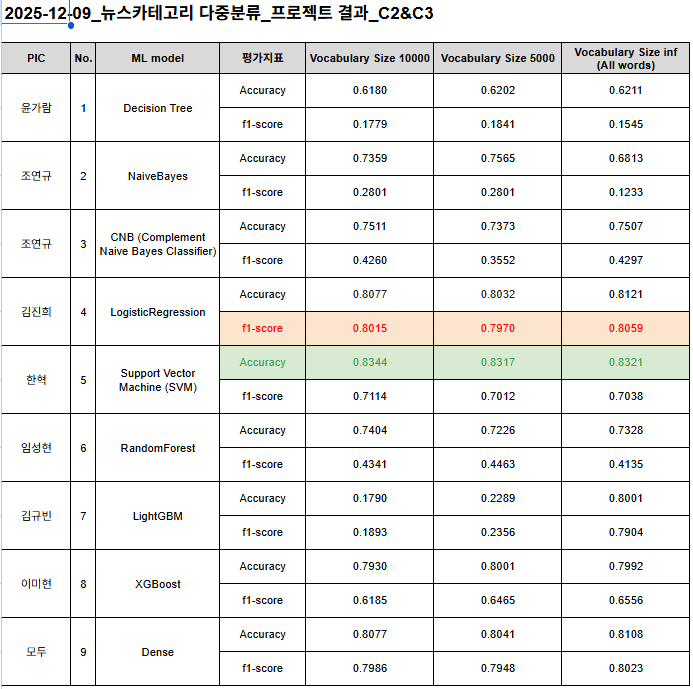

## 실험 내용

- Vocabulary Size(단어장개수)를 바꾸면서 (**10000, 5000, Nan**)
- 8개 이상의 ML모델 (**Logistic Regression, Support Vector Machine (SVM), RandomForest, XGBoost, Naive Bayes, LightGBM, Decision Tree, Complement Naive Bayes(CNB), GradientBoostingClassifier, VotingClassifier (soft voting**)을 사용해보고  
accuacry와 f1-score를 비교하기
(벡터화는 tf-idf로 통일)

- 딥러닝과 머신런닝의 차이 비교하기

## 회고

- 단어장개수가 증가하면 Logistic Regression, SVM, XGBoost, Dense 모델의 경우 정보량 증가를 통해 성능이 향상됐다. 한편 트리기반/Naive Bayes 모델의 경우 희귀 단어 증가로 인해 성능이 하락했다.
- **제일좋은 모델**은 **SVM** 이었다. 고차원 sparse 벡터에 강한 알고리즘이란게 대표적인 장점이다. 그 다음으로 Logistic Regression이 높은 성능을 보였다.
- Dense(딥러닝) 모델은 Logistic Regression 수준의 안정적 성능을 보였다. 전체단어장에서 성능이 최고였다. 고차원 sparse 벡터에 매우 강함을 알 수 있었다.

In [3]:
from tensorflow.keras.datasets import reuters
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# 데이터 준비
## index -> text
## DTM , TF-idf 학습데이터 준비

In [4]:
# 이부분에있는 num_words를 None/10000/5000으로 바꿔보세요~

(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)

2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


In [5]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

550378/550378 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


In [6]:
index_to_word = { index+3 : word for word, index in word_index.items() }
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

In [7]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded
print(len(x_train))

8982


In [8]:
decoded_test = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded_test.append(t)

x_test = decoded_test
print(len(x_test))

2246


In [9]:
# 벡터화 DTM, TF-idf 방법
dtmvector = CountVectorizer()

tfidf_transformer = TfidfTransformer()

x_train_dtm = dtmvector.fit_transform(x_train)
x_test_dtm= dtmvector.transform(x_test)

x_train_tfidf = tfidf_transformer.fit_transform(x_train_dtm)
x_test_tfidf = tfidf_transformer.transform(x_test_dtm)

In [10]:
x_train_tfidf.shape

(8982, 4867)

In [11]:
x_test_tfidf.shape

(2246, 4867)

In [12]:
x_train[3]

"<sos> the farmers home administration the u s agriculture department's farm lending arm could lose about seven billion dlrs in outstanding principal on its severely <unk> borrowers or about one fourth of its farm loan portfolio the general accounting office gao said in remarks prepared for delivery to the senate agriculture committee brian <unk> senior associate director of gao also said that a preliminary analysis of proposed changes in <unk> financial <unk> standards indicated as many as one half of <unk> borrowers who received new loans from the agency in 1986 would be <unk> under the proposed system the agency has proposed <unk> <unk> credit using a variety of financial <unk> instead of <unk> <unk> on <unk> ability senate agriculture committee chairman <unk> <unk> d <unk> <unk> the proposed <unk> changes telling <unk> administrator <unk> clark at a hearing that they would mark a dramatic shift in the <unk> purpose away from being <unk> <unk> of last <unk> toward becoming a big cit

# 모델 정의 및 실험

여러가지 모델을 바꾸며 실험해보세요~

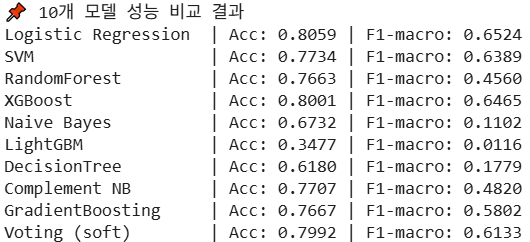

In [26]:
# TF-idf데이터로 ML모델(10개) 학습 및 결과 비교

results = {}

# 1) Logistic Regression
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
log_model.fit(x_train_tfidf, y_train)

y_pred = log_model.predict(x_test_tfidf)

results["Logistic Regression"] = (
    accuracy_score(y_test, y_pred),
    f1_score(y_test, y_pred, average="macro")
)

# 2) SVM (LinearSVC)
from sklearn.svm import LinearSVC

svm_model = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
svm_model.fit(x_train_tfidf, y_train)

y_pred = svm_model.predict(x_test_tfidf)

results["SVM"] = (
    accuracy_score(y_test, y_pred),
    f1_score(y_test, y_pred, average="macro")
)

# 3) RandomForest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=300)
rf_model.fit(x_train_tfidf, y_train)

y_pred = rf_model.predict(x_test_tfidf)

results["RandomForest"] = (
    accuracy_score(y_test, y_pred),
    f1_score(y_test, y_pred, average="macro")
)

# 4) XGBoost
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators=100, max_depth=5, eval_metric='mlogloss')
xgb_model.fit(x_train_tfidf, y_train)

y_pred = xgb_model.predict(x_test_tfidf)

results["XGBoost"] = (
    accuracy_score(y_test, y_pred),
    f1_score(y_test, y_pred, average="macro")
)

# 5) Naive Bayes
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(x_train_tfidf, y_train)

y_pred = nb_model.predict(x_test_tfidf)

results["Naive Bayes"] = (
    accuracy_score(y_test, y_pred),
    f1_score(y_test, y_pred, average="macro")
)

# 6) LightGBM
from lightgbm import LGBMClassifier

lgb_model = LGBMClassifier(num_leaves=64, n_estimators=200)
lgb_model.fit(x_train_tfidf, y_train)

y_pred = lgb_model.predict(x_test_tfidf)

results["LightGBM"] = (
    accuracy_score(y_test, y_pred),
    f1_score(y_test, y_pred, average="macro")
)

# 7) Decision Tree
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(max_depth=10, random_state=0)
dt_model.fit(x_train_tfidf, y_train)

y_pred = dt_model.predict(x_test_tfidf)

results["DecisionTree"] = (
    accuracy_score(y_test, y_pred),
    f1_score(y_test, y_pred, average="macro")
)

# 8) Complement Naive Bayes
from sklearn.naive_bayes import ComplementNB

cnb_model = ComplementNB()
cnb_model.fit(x_train_tfidf, y_train)

y_pred = cnb_model.predict(x_test_tfidf)
results["Complement NB"] = (
    accuracy_score(y_test, y_pred),
    f1_score(y_test, y_pred, average="macro")
)

# 9) GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(random_state=0) # verbose=3
gb_model.fit(x_train_tfidf, y_train)

y_pred = gb_model.predict(x_test_tfidf)
results["GradientBoosting"] = (
    accuracy_score(y_test, y_pred),
    f1_score(y_test, y_pred, average="macro")
)

# 10) VotingClassifier (soft voting)
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(penalty='l2', max_iter=1000)),
        ('cnb', ComplementNB()),
        ('gb', GradientBoostingClassifier())
    ],
    voting='soft'   # << soft voting 설정
)

voting_clf.fit(x_train_tfidf, y_train)
y_pred = voting_clf.predict(x_test_tfidf)

results["Voting (soft)"] = (
    accuracy_score(y_test, y_pred),
    f1_score(y_test, y_pred, average="macro")
)

# 최종 성능 비교 출력
print("📌 10개 모델 성능 비교 결과")
for model, (acc, f1) in results.items():
    print(f"{model:20s} | Acc: {acc:.4f} | F1-macro: {f1:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


📌 10개 모델 성능 비교 결과
Logistic Regression  | Acc: 0.8059 | F1-macro: 0.6524
SVM                  | Acc: 0.7734 | F1-macro: 0.6389
RandomForest         | Acc: 0.7663 | F1-macro: 0.4560
XGBoost              | Acc: 0.8001 | F1-macro: 0.6465
Naive Bayes          | Acc: 0.6732 | F1-macro: 0.1102
LightGBM             | Acc: 0.3477 | F1-macro: 0.0116
DecisionTree         | Acc: 0.6180 | F1-macro: 0.1779
Complement NB        | Acc: 0.7707 | F1-macro: 0.4820
GradientBoosting     | Acc: 0.7667 | F1-macro: 0.5802
Voting (soft)        | Acc: 0.7992 | F1-macro: 0.6133


# Dense NN 딥러닝 모델

In [13]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

input_dim = x_train_tfidf.shape[1]

inputs = Input(shape=(input_dim,))
x = Dense(512, activation='relu')(inputs)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(46, activation='softmax')(x)    # 클래스 46개

dense_model = Model(inputs, outputs)
dense_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
dense_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4867)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,492,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 46)             │         5,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,564,014 (9.78 MB)

 Trainable params: 2,564,014 (9.78 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
dense_model.fit(x_train_tfidf, y_train, epochs=10, batch_size=32, verbose=0)

y_pred_proba = dense_model.predict(x_test_tfidf)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ F1-score: {f1:.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
✅ Accuracy: 0.8063
✅ F1-score: 0.8017
